In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
prices = pd.read_csv('../input/btc2021/full_data__1__2021.csv/full_data__1__2021.csv')
sentiment = pd.read_csv('../input/btc2021/BTC-tweets-sentiment-prices.csv')

sentiment.head()

,date,vader_negative,vader_neutral,vader_positive,tweet_length,vader_scale,tweets_vol,Close
0,2021-02-05 10:00:00,0.000,9.207,0.793,161.0,35.0,10.0,37481.900629
1,2021-02-05 11:00:00,0.961,36.106,2.933,616.0,135.0,40.0,37607.173100
2,2021-02-05 12:00:00,0.959,58.419,6.622,1041.0,215.0,66.0,37876.993022
3,2021-02-05 13:00:00,1.407,53.897,3.696,920.0,204.0,59.0,37984.115288
4,2021-02-05 14:00:00,1.039,69.741,4.220,1116.0,266.0,75.0,38161.923202


In [4]:
sentiment.shape

(7886, 8)

In [5]:
sentiment.isna().sum()

date                0
vader_negative      0
vader_neutral       0
vader_positive      0
tweet_length        0
vader_scale         0
tweets_vol          0
Close             192
dtype: int64

In [6]:
sentiment.dropna(axis=0, inplace=True)

In [7]:
sentiment.shape

(7694, 8)

In [8]:
sentiment.set_index('date', inplace=True)

In [9]:
prices = sentiment[['Close']]
prices.tail()

,Close
date,
2021-12-22 19:00:00,48768.659833
2021-12-22 20:00:00,48962.783500
2021-12-22 21:00:00,48972.488667
2021-12-22 22:00:00,48927.945667
2021-12-22 23:00:00,48751.322045


## Data Preprocessing

### 1. Sentiment Preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

X = sentiment.iloc[:, :-1]
y = sentiment[['Close']]

train_split = 0.9
data_len = int(y.shape[0] * train_split)

features_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler()

X = features_scaler.fit_transform(X)
y = target_scaler.fit_transform(y)

X_train = X[:data_len]
y_train = y[:data_len]
X_test = X[data_len:]
y_test = y[data_len:]

### Add TimeStamp

As we working with multi input model, we can not fit our model with generators, so we have to do it manually.

In [11]:
# split a multivariate sequence into samples
def Timeseries_sequences(sequences, target, length,):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + length
        # check if we are beyond the dataset
        if end_ix > len(sequences) - 1: 
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], target[end_ix-1, :] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
sr = 2
lb = 24*sr # hours

X_train_sent, y_train_sent = Timeseries_sequences(X_train, y_train, length=lb)
X_test_sent, y_test_sent = Timeseries_sequences(X_test, y_test, length=lb)

In [13]:
X_train_sent.shape, y_train_sent.shape

((6876, 48, 6), (6876, 1))

### 2. Prices Preprocessing

In [14]:
X_train_price, y_train_price = Timeseries_sequences(y_train, y_train, length=lb)
X_test_price, y_test_price = Timeseries_sequences(y_test, y_test, length=lb)

## Model

In [15]:
import tensorflow as tf

from tensorflow.keras.models import Model
#from keras.layers.merge import concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from tensorflow.keras.optimizers import SGD, Adam

In [16]:
sent_shape = X_train_sent.shape[1:]
price_shape = X_train_price.shape[1:]

sent_shape, price_shape

((48, 6), (48, 1))

In [17]:
# design a parallel model

sent_input = Input(shape=sent_shape, name='sentiment_input') # x1
price_input = Input(shape=price_shape, name='prices_input') # x2

# sentiment Network
x1 = LSTM(32, return_sequences=True, name='sentiment_LSTM_sequences')(sent_input)
x1 = LSTM(4, name='sentiment_LSTM')(x1)
x1 = Dense(4, name='sentiment_vector_representation')(x1)

# prices Network
x2 = LSTM(10, name='prices_LSTM')(price_input)
x2 = Dense(4, name='prices_vector_representation')(x2)

# concatenate both
out = Concatenate(axis=-1, name='merge')([x1, x2])

# fully-connected
out = Dense(1, name='output')(out)

model = Model(inputs=[sent_input, price_input], outputs=out)

# show model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentiment_input (InputLayer)    [(None, 48, 6)]      0                                            
__________________________________________________________________________________________________
sentiment_LSTM_sequences (LSTM) (None, 48, 32)       4992        sentiment_input[0][0]            
__________________________________________________________________________________________________
prices_input (InputLayer)       [(None, 48, 1)]      0                                            
__________________________________________________________________________________________________
sentiment_LSTM (LSTM)           (None, 4)            592         sentiment_LSTM_sequences[0][0]   
______________________________________________________________________________________________

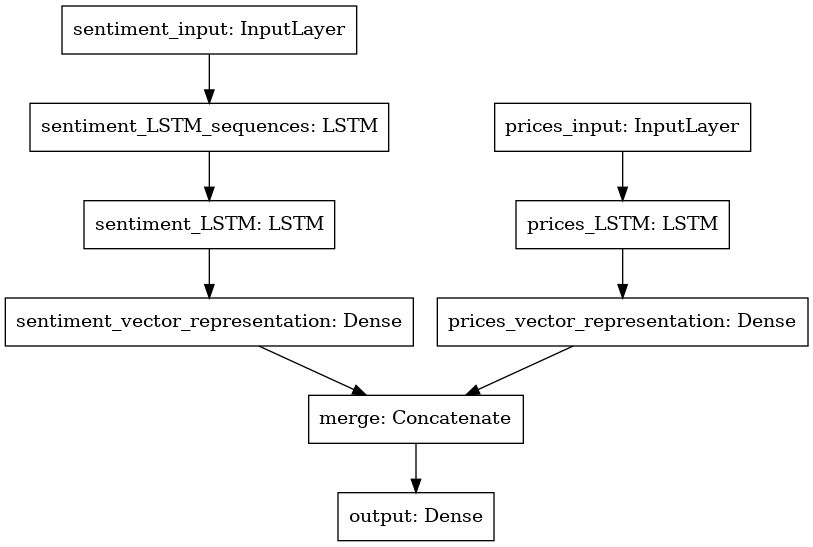

In [18]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    #show_layer_activations=False,
)

In [19]:
# model callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

# loss function
huber_loss = tf.keras.losses.Huber()
model.compile(loss='mse', optimizer=Adam(learning_rate=0.1))

# Traning
history = model.fit([X_train_sent, X_train_price], y_train_price,
                    validation_data=([X_test_sent, X_test_price], y_test_price), 
                    batch_size=256,
                    shuffle=False,
                    callbacks=[es, reduce_lr],
                    epochs=1000,
                    verbose=1,
                   )

Epoch 1/1000
27/27 [==============================] - 9s 68ms/step - loss: 0.0737 - val_loss: 0.0331
Epoch 2/1000
27/27 [==============================] - 0s 17ms/step - loss: 0.0190 - val_loss: 0.0079
Epoch 3/1000
27/27 [==============================] - 0s 15ms/step - loss: 0.0099 - val_loss: 0.0040
Epoch 4/1000
27/27 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 5/1000
27/27 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 6.8085e-04
Epoch 6/1000
27/27 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 6.4114e-04
Epoch 7/1000
27/27 [==============================] - 0s 15ms/step - loss: 9.6132e-04 - val_loss: 6.9511e-04
Epoch 8/1000
27/27 [==============================] - 0s 15ms/step - loss: 8.6224e-04 - val_loss: 6.9382e-04
Epoch 9/1000
27/27 [==============================] - 0s 15ms/step - loss: 8.0856e-04 - val_loss: 6.6452e-04
Epoch 10/1000
27/27 [==============================] - 1s 2

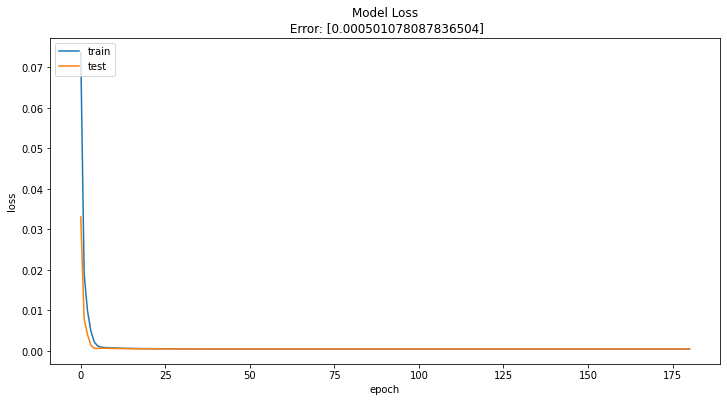

In [20]:
# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"Model Loss\n Error: [{np.min(history.history['val_loss'])}]")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predictions

In [21]:
# predict and compare
pred = target_scaler.inverse_transform(model.predict([X_test_sent, X_test_price]))
true = target_scaler.inverse_transform(y_test_price)

print('Real Mean-Aabsolute-Error:', np.mean(abs(pred-true)))

Real Mean-Aabsolute-Error: 608.7235711450166


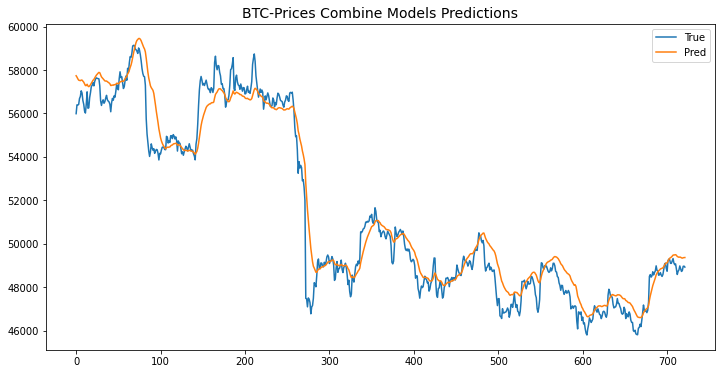

In [22]:
# plot the results
plt.figure(figsize=(12, 6))
plt.plot(true, label='True');
plt.plot(pred, label='Pred')
plt.title(f'BTC-Prices Combine Models Predictions', fontsize=14)
plt.legend();

## Conclusion:

**The Real Mean-Aabsolute-Error is very good, also predictions fit very well, even better than each model alone.**